# **プロダクト開発演習**

#### ●目的
複数の物体が移った画像から20カテゴリの項目について学習し、  
正しく検知できる物体検知モデルの作成を行う。  
（参考テーマ課題番号002に類似）

#### ●データセット
PASCAL VOC 2012（コンテスト）のデータセット

#### ●学習に用いたモデル
SSD（Single Shot multibox Detector）<br><br>
![model_image](https://drive.google.com/uc?id=1HL_wNkxL2n1oW3ADM8u1cczPOKxYUpvQ)

#### ●カテゴリ
|  | category      | japanese          |
|--|---------------|-------------------|
|1 |aeroplane      |飛行機             |
|2 |bicycle        |自転車             |
|3 |bird           |鳥                 |
|4 |boat           |ボート             |
|5 |bottle         |水筒               |
|6 |bus            |バス               |
|7 |car            |車                 |
|8 |cat            |猫                 |
|9 |chair          |椅子               |
|10|cow            |牛                 |
|11|diningtable    |ダイニングテーブル |
|12|dog            |犬                 |
|13|horse          |馬                 |
|14|motorbike      |バイク             |
|15|person         |人                 |
|16|pottedplant    |植木鉢             |
|17|sheep          |羊                 |
|18|sofa           |ソファー           |
|19|train          |電車               |
|20|tvmonitor      |テレビモニター     |

#### ●開発環境
開発ツール：google colab  
ライブラリのバージョン：pytorch=1.11.0 / torchvision=0.12.0  
備考：学習時はgoogole colab proにてGPU V100（ハイメモリ）で実行

#### ●学習データ数
5717枚

#### ●主なハイパーパラメータの設定
ミニバッチの数：30  
エポック数：15


### 【Google colabのみ実行】ライブラリのインストール

必要なライブラリのインストールと、実行環境のバージョンを統一します。<br>

※以下のセルを実行しましたら、「ランタイム」→「ランタイムを再起動」により<font color=Red>再起動</font>を行ってください。

In [1]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # ライブラリのインストール
    !pip install torch==1.11.0 torchvision==0.12.0
else:
    print("Not Google Colab")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 750.6/750.6 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.4.0+cu121
    Uninstalling torch-2.4.0+cu121:
      Successfully uninstalled torch-2.4.0+cu121
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.19.0+cu121
    Uninstalling torchvision-0.19.0+cu121:
      Successfully uninstalled torchvision-0.19.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.4.0+cu121 requires torch==2.4.0, but you have torch 1.11.0 which is incompatible.


### 【Google colabのみ実行】ドライブのマウント

Google Colabでは、**マウント**という作業を行って、Googleドライブ内のファイルを操作できる状態にする必要があります。<br>
<br>
以下のコードを実行してマウントしてください。なお、認証で**Googleアカウントへのログインが必要**になります。

In [3]:
import sys
# Google colab環境であるか判定
if 'google.colab' in sys.modules:
    # マウントを行う
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Not Google Colab")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### ライブラリのインストール

使用するライブラリはたいていimportできますが、別途インストールが必要なライブラリもあります。<br>

その場合は下記コードで使用したいライブラリをインストールしてから、importで利用しましょう。<br>

## ライブラリのインポート

In [5]:
import os
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Function
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from math import sqrt as sqrt
from itertools import product as product
import xml.etree.ElementTree as ET
import pickle
import types

#### **ここから実際のモデリング（SSD）を始める**

#### **SSDモデルの実装**

##### **VGGネットワークの実装**

In [12]:
# 全て3x3のフィルターと大きさ1のpaddingを利用する
def make_vgg():
    cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C',
           512, 512, 512, 'M', 512, 512, 512]
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'C':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6)
    conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
    layers += [pool5, conv6, nn.ReLU(inplace=True), conv7, nn.ReLU(inplace=True)]
    return nn.ModuleList(layers)

##### **extrasネットワークの実装**

In [13]:
def make_extras():
    layers = [
        nn.Conv2d(1024, 256, kernel_size=(1)),
        nn.Conv2d(256, 512, kernel_size=(3), stride=2, padding=1),
        nn.Conv2d(512, 128, kernel_size=(1)),
        nn.Conv2d(128, 256, kernel_size=(3), stride=2, padding=1),
        nn.Conv2d(256, 128, kernel_size=(1)),
        nn.Conv2d(128, 256, kernel_size=(3)),
        nn.Conv2d(256, 128, kernel_size=(1)),
        nn.Conv2d(128, 256, kernel_size=(3))
    ]
    return nn.ModuleList(layers)

##### **locネットワークの実装**
（作成されるDBox個数）×4

In [14]:
def make_loc(num_classes=21):
    layers = [
        # out1に対する処理
        nn.Conv2d(512, 4*4, kernel_size=3, padding=1),
        # out2に対する処理
        nn.Conv2d(1024, 6*4, kernel_size=3, padding=1),
        # out3に対する処理
        nn.Conv2d(512, 6*4, kernel_size=3, padding=1),
        # out4に対する処理
        nn.Conv2d(256, 6*4, kernel_size=3, padding=1),
        # out5に対する処理
        nn.Conv2d(256, 4*4, kernel_size=3, padding=1),
        # out6に対する処理
        nn.Conv2d(256, 4*4, kernel_size=3, padding=1),
    ]
    return nn.ModuleList(layers)

##### **confネットワークの実装**
num_classesは物体検出のラベルの種類数である
（作成されるDBox個数）×（クラスの種類数=num_classes）

In [15]:
def make_conf(num_classes=21):
    layers = [
        # out1に対する処理
        nn.Conv2d(512, 4*num_classes, kernel_size=3, padding=1),
        # out2に対する処理
        nn.Conv2d(1024, 6*num_classes, kernel_size=3, padding=1),
        # out3に対する処理
        nn.Conv2d(512, 6*num_classes, kernel_size=3, padding=1),
        # out4に対する処理
        nn.Conv2d(256, 6*num_classes, kernel_size=3, padding=1),
        # out5に対する処理
        nn.Conv2d(256, 4*num_classes, kernel_size=3, padding=1),
        # out6に対する処理
        nn.Conv2d(256, 4*num_classes, kernel_size=3, padding=1),
    ]
    return nn.ModuleList(layers)

##### **L2Normの実装**

In [16]:
class L2Norm(nn.Module):
    def __init__(self, n_channels=512, scale=20):
        super(L2Norm, self).__init__()
        self.n_channels = n_channels
        self.gamma = scale
        self.eps = 1e-10
        self.weight = nn.Parameter(torch.Tensor(self.n_channels))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.constant_(self.weight, self.gamma)

    def forward(self, x):
        norm = x.pow(2).sum(dim=1, keepdim=True).sqrt()+self.eps
        x = torch.div(x, norm)
        out = self.weight.unsqueeze(0).unsqueeze(2).unsqueeze(3).expand_as(x) * x
        return out

#### **DBoxの実装**

In [17]:
class PriorBox(object):
    def __init__(self):
        super(PriorBox, self).__init__()
        self.image_size = 300
        self.feature_maps = [38, 19, 10, 5, 3, 1]
        self.steps = [8, 16, 32, 64, 100,  300]
        self.min_sizes = [30, 60, 111, 162, 213, 264]
        self.max_sizes = [60, 111, 162, 213, 164, 315]
        self.aspect_ratios = [[2], [2, 3], [2, 3], [2, 3], [2], [2]]

    def forward(self):
        mean = []
        for k, f in enumerate(self.feature_maps):
            for i, j in product(range(f), repeat=2):
                f_k = self.image_size / self.steps[k]
                cx = (j + 0.5) / f_k
                cy = (i + 0.5) / f_k
                s_k = self.min_sizes[k] / self.image_size
                mean += [cx, cy, s_k, s_k]
                s_k_prime = sqrt(s_k * (self.max_sizes[k] / self.image_size))
                mean += [cx, cy, s_k_prime, s_k_prime]
                for ar in self.aspect_ratios[k]:
                    mean += [cx, cy, s_k * sqrt(ar), s_k / sqrt(ar)]
                    mean += [cx, cy, s_k / sqrt(ar), s_k * sqrt(ar)]
        output = torch.Tensor(mean).view(-1, 4)
        output.clamp_(max=1, min=0)
        return output

##### ***myfunction***

In [18]:
def point_form(boxes):
    """ Convert prior_boxes to (xmin, ymin, xmax, ymax)
    representation for comparison to point form ground truth data.
    Args:
        boxes: (tensor) center-size default boxes from priorbox layers.
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, :2] - boxes[:, 2:]/2,     # xmin, ymin
                      boxes[:, :2] + boxes[:, 2:]/2), 1)  # xmax, ymax


def center_size(boxes):
    """ Convert prior_boxes to (cx, cy, w, h)
    representation for comparison to center-size form ground truth data.
    Args:
        boxes: (tensor) point_form boxes
    Return:
        boxes: (tensor) Converted xmin, ymin, xmax, ymax form of boxes.
    """
    return torch.cat((boxes[:, 2:] + boxes[:, :2])/2,  # cx, cy
                      boxes[:, 2:] - boxes[:, :2], 1)  # w, h


def intersect(box_a, box_b):
    """ We resize both tensors to [A,B,2] without new malloc:
    [A,2] -> [A,1,2] -> [A,B,2]
    [B,2] -> [1,B,2] -> [A,B,2]
    Then we compute the area of intersect between box_a and box_b.
    Args:
      box_a: (tensor) bounding boxes, Shape: [A,4].
      box_b: (tensor) bounding boxes, Shape: [B,4].
    Return:
      (tensor) intersection area, Shape: [A,B].
    """
    A = box_a.size(0)
    B = box_b.size(0)
    max_xy = torch.min(box_a[:, 2:].unsqueeze(1).expand(A, B, 2),
                       box_b[:, 2:].unsqueeze(0).expand(A, B, 2))
    min_xy = torch.max(box_a[:, :2].unsqueeze(1).expand(A, B, 2),
                       box_b[:, :2].unsqueeze(0).expand(A, B, 2))
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]


def jaccard(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.  Here we operate on
    ground truth boxes and default boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: (tensor) Ground truth bounding boxes, Shape: [num_objects,4]
        box_b: (tensor) Prior boxes from priorbox layers, Shape: [num_priors,4]
    Return:
        jaccard overlap: (tensor) Shape: [box_a.size(0), box_b.size(0)]
    """
    inter = intersect(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1])).unsqueeze(1).expand_as(inter)  # [A,B]
    area_b = ((box_b[:, 2]-box_b[:, 0]) *
              (box_b[:, 3]-box_b[:, 1])).unsqueeze(0).expand_as(inter)  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

## match に入力されるのは１つの教師データに対する情報
## 複数の BB と ラベルがある

def match(threshold, truths, priors, variances, labels, loc_t, conf_t, idx):
    """Match each prior box with the ground truth box of the highest jaccard
    overlap, encode the bounding boxes, then return the matched indices
    corresponding to both confidence and location preds.
    Args:
        threshold: (float) The overlap threshold used when mathing boxes.
        truths: (tensor) Ground truth boxes, Shape: [num_obj, num_priors].
            BB と ラベル １データに対するもの複数ある
        priors: (tensor) Prior boxes from priorbox layers, Shape: [n_priors,4].
            デフォルトボックス、8732 個、４次元で表現
        variances: (tensor) Variances corresponding to each prior coord,
            Shape: [num_priors, 4].
            decode するときの変数
        labels: (tensor) All the class labels for the image, Shape: [num_obj].
            ラベルの集合
        loc_t: (tensor) Tensor to be filled w/ endcoded location targets.
            返り値？？
        conf_t: (tensor) Tensor to be filled w/ matched indices for conf preds.
            返り値？？
        idx: (int) current batch index
            入力されたデータは batch の何番目のデータか index
    Return:
        The matched indices corresponding to 1)location and 2)confidence preds.
        loc_t[idx] と conf_t[idx] で loc_t と conf_t の配列を作っている
        loc_t[idx] --> [8732,4] 複数 BB があるが１つだけが取り出されている
        conf_t[idx] --> [8732] 複数 BB があるが１つだけが取り出されている
    """
    # jaccard index
    overlaps = jaccard(truths,point_form(priors))
    # ここで返ってくるのは BB の個数分の 8732 の DB との IOU --> [3, 8732]
    # (Bipartite Matching)
    # [1,num_objects] best prior for each ground truth
    best_prior_overlap, best_prior_idx = overlaps.max(1, keepdim=True)
    ## --> 各 BB に対する最大の IOU とその DB の index
    # [1,num_priors] best ground truth for each prior
    best_truth_overlap, best_truth_idx = overlaps.max(0, keepdim=True)
    ## --> 各 BB に対する各 DB との IOU の一覧で最大値を取ったもの
    ## 何番目の BB だったかが best_truth_idx
    best_truth_idx.squeeze_(0)  ## [1,8732] --> [8732]
    best_truth_overlap.squeeze_(0)  ## [1,8732] --> [8732]
    best_prior_idx.squeeze_(1)  ## [3,1] --> [3]
    best_prior_overlap.squeeze_(1)  ## [3,1] --> [3]
    best_truth_overlap.index_fill_(0, best_prior_idx, 2)  # ensure best prior
    # TODO refactor: index  best_prior_idx with long tensor
    # ensure every gt matches with its prior of max overlap
    for j in range(best_prior_idx.size(0)):
        best_truth_idx[best_prior_idx[j]] = j
    matches = truths[best_truth_idx]          # Shape: [num_priors,4]
    conf = labels[best_truth_idx] + 1         # Shape: [num_priors]  各 DB のクラス
    conf[best_truth_overlap < threshold] = 0  # label as background  thr 以下は背景
    loc = encode(matches, priors, variances)  ## 各 DB に対してオフセットの値へ
    loc_t[idx] = loc    # [num_priors,4] encoded offsets to learn
    conf_t[idx] = conf  # [num_priors] top class label for each prior

## それぞれの DBox に対して最も合っている BB とのオフセットとラベルを返している

def encode(matched, priors, variances):
    """Encode the variances from the priorbox layers into the ground truth boxes
    we have matched (based on jaccard overlap) with the prior boxes.
    Args:
        matched: (tensor) Coords of ground truth for each prior in point-form
            Shape: [num_priors, 4].
        priors: (tensor) Prior boxes in center-offset form
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        encoded boxes (tensor), Shape: [num_priors, 4]
    """
    # dist b/t match center and prior's center
    g_cxcy = (matched[:, :2] + matched[:, 2:])/2 - priors[:, :2]
    # encode variance
    g_cxcy /= (variances[0] * priors[:, 2:])
    # match wh / prior wh
    g_wh = (matched[:, 2:] - matched[:, :2]) / priors[:, 2:]
    g_wh = torch.log(g_wh) / variances[1]
    # return target for smooth_l1_loss
    return torch.cat([g_cxcy, g_wh], 1)  # [num_priors,4]


def decode(loc, priors, variances):
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """

    boxes = torch.cat((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * torch.exp(loc[:, 2:] * variances[1])), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes


def log_sum_exp(x):
    """Utility function for computing log_sum_exp while determining
    This will be used to determine unaveraged confidence loss across
    all examples in a batch.
    Args:
        x (Variable(tensor)): conf_preds from conf layers
    """
    x_max = x.data.max()
    return torch.log(torch.sum(torch.exp(x-x_max), 1, keepdim=True)) + x_max


def nms(boxes, scores, overlap=0.45, top_k=200):
    """Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """

    keep = scores.new(scores.size(0)).zero_().long()
    if boxes.numel() == 0:
        return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)

    v, idx = scores.sort(0)  # sort in ascending order
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals

    # keep = torch.Tensor()
    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        xx1 = torch.index_select(x1, 0, idx)
        yy1 = torch.index_select(y1, 0, idx)
        xx2 = torch.index_select(x2, 0, idx)
        yy2 = torch.index_select(y2, 0, idx)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count

#### **detectionの実装**

In [19]:
class Detect(Function):
  def forward(self, output, num_classes,
              top_k=200, variance=[0.1, 0.2],
              conf_thresh=0.01, nms_thresh=0.45):
    loc_data, conf_data, prior_data = output[0], output[1], output[2]
    # conf_dataは各クラスの信頼度、[bs, 8732, num_classes]
    # 信頼度の部分をSoftmaxで確率に直す
    softmax = nn.Softmax(dim=-1)
    conf_data = softmax(conf_data)
    # numはbatchの大きさ
    num = loc_data.size(0)
    # 出力の配列を準備、中身は今は0、[bs, 21, 200, 5]
    output = torch.zeros(num, num_classes, top_k, 5)
    # conf_data [bs, 8732, num_classes]を
    # [bs, num_classes, 8732]に変形してconf_predsと名付ける
    conf_preds = conf_data.transpose(2, 1)
    # Decode predictions into bboxes.
    for i in range(num): # バッチ内の各データの処理
        # loc_dataとDBoxからBBoxを作成
        decoded_boxes = decode(loc_data[i], prior_data, variance)
        # conf_predsをconf_scoresにハードコピー
        conf_scores = conf_preds[i].clone()
        for cl in range(1, num_classes):
            # conf_scoreで信頼度がconf_thresh以上のindexを求める
            c_mask = conf_scores[cl].gt(conf_thresh)
            # conf_thresh以上の信頼度の集合を作る
            scores = conf_scores[cl][c_mask]
            # その集合の要素数が0、つまりconf_thresh異常はない
            # これ以降の処理はなしで、次のクラスへ
            if scores.size(0) == 0:
                continue
            # c_maskをdecoded_boxesに適用できるようにサイズ変更
            l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
            # l_maskをdecoded_boxesに適用、1次元になる
            # view(-1, 4)でサイズを戻す
            boxes = decoded_boxes[l_mask].view(-1, 4)
            # boxesに対してnmsを適用、
            # idsはnumsを通過したBBoxのindex
            # countはnumsを通過したBBoxの数
            ids, count = nms(boxes, scores, nms_thresh, top_k)
            # 上記の結果をoutputに格納
            output[i, cl, :count] = torch.cat((scores[ids[:count]].unsqueeze(1), boxes[ids[:count]]), 1)

    return output

#### **SSDのforward関数**

In [20]:
class SSD(nn.Module):
    def __init__(self, phase='train', num_classes=21):
        super(SSD, self).__init__()
        self.phase = phase
        self.num_classes = num_classes
        self.vgg = make_vgg()
        self.extras = make_extras()
        self.L2Norm = L2Norm()
        self.loc = make_loc()
        self.conf = make_conf()
        dbox = PriorBox()
        self.priors = dbox.forward()
        if phase == 'test':
            self.detect = Detect()

    def forward(self, x):
        bs = len(x)
        out, lout, cout = [], [], []

        for i in range(23):
            x = self.vgg[i](x)
        x1 = x
        out.append(self.L2Norm(x1)) # out1を出力

        for i in range(23, len(self.vgg)):
            x = self.vgg[i](x)
        out.append(x) # out2を出力

        for i in range(0, 8, 2):
            x = F.relu(self.extras[i](x), inplace=True)
            x = F.relu(self.extras[i+1](x), inplace=True)
            out.append(x) # out3-out6を出力

        for i in range(6):
            lx = self.loc[i](out[i]).permute(0, 2, 3, 1).reshape(bs, -1, 4)
            cx = self.conf[i](out[i]).permute(0, 2, 3, 1).reshape(bs, -1, self.num_classes)
            lx = self.loc[i](out[i]).permute(0, 2, 3, 1).reshape(bs, -1, 4)
            cx = self.conf[i](out[i]).permute(0, 2, 3, 1).reshape(bs, -1, self.num_classes)
            lout.append(lx)
            cout.append(cx)
        lout = torch.cat(lout, 1)
        cout = torch.cat(cout, 1)

        output = (lout, cout, self.priors)
        if self.phase == 'test':
            return self.detect.apply(output, self.num_classes)
        else:
            return output

#### **損失関数の実装**

In [21]:
class MultiBoxLoss(nn.Module):
    def __init__(self, num_classes=21, overlap_thresh=0.5, neg_pos=3, device='cpu'):
        super(MultiBoxLoss, self).__init__()
        self.num_classes = num_classes
        self.threshold = overlap_thresh
        self.negpos_ratio = neg_pos
        self.variance = [0.1, 0.2]
        self.device = device

    def forward(self, predictions, targets):
        loc_data, conf_data, priors = predictions
        num = loc_data.size(0)  # batch size
        priors = priors[:loc_data.size(1), :]  ## 8732*4
        num_priors = (priors.size(0))  ## 8732  カッコ必要？
        num_classes = self.num_classes
        ## オフセットを入れる箱
        loc_t = torch.Tensor(num, num_priors, 4).to(self.device)
        ## conf_t : torch.Size([4, 8732]) どの DBox か
        conf_t = torch.LongTensor(num, num_priors).to(self.device)
        for idx in range(num):   ## num は bs、各教師 image データに対して
            ## BB の位置情報 4次元、複数個
            truths = targets[idx][:, :-1].to(self.device)
            ## BB のラベル、複数個
            labels = targets[idx][:, -1].to(self.device)
            ## DBox を gpu へ
            defaults = priors.to(self.device)
            match(self.threshold, truths, defaults,
                  self.variance, labels, loc_t, conf_t, idx)
        pos = conf_t > 0  ## 背景ではないもの
        # Localization Loss (Smooth L1)
        # Shape: [batch,num_priors,4]
        pos_idx = pos.unsqueeze(pos.dim()).expand_as(loc_data)
        loc_p = loc_data[pos_idx].view(-1, 4)
        loc_t = loc_t[pos_idx].view(-1, 4)
        loss_l = F.smooth_l1_loss(loc_p, loc_t, reduction='sum')
        # Compute max conf across batch for hard negative mining
        batch_conf = conf_data.view(-1, self.num_classes)
        loss_c = F.cross_entropy(batch_conf, conf_t.view(-1), reduction='none')
        # Hard Negative Mining
        num_pos = pos.long().sum(1, keepdim=True)
        loss_c = loss_c.view(num, -1)
        loss_c[pos] = 0  # filter out pos boxes for now
        _, loss_idx = loss_c.sort(1, descending=True)
        _, idx_rank = loss_idx.sort(1)
        num_neg = torch.clamp(self.negpos_ratio*num_pos, max=pos.size(1)-1)
        neg = idx_rank < num_neg.expand_as(idx_rank)
        # Confidence Loss Including Positive and Negative Examples
        pos_idx = pos.unsqueeze(2).expand_as(conf_data)
        neg_idx = neg.unsqueeze(2).expand_as(conf_data)
        conf_p = conf_data[(pos_idx+neg_idx).gt(0)].view(-1, self.num_classes)
        targets_weighted = conf_t[(pos+neg).gt(0)]
        loss_c = F.cross_entropy(conf_p, targets_weighted, reduction='sum')
        # Sum of losses: L(x,c,l,g) = (Lconf(x, c) + αLloc(x,l,g)) / N
        N = num_pos.data.sum()
        loss_l /= N
        loss_c /= N
        return loss_l, loss_c

### **学習プログラム全体の実装**

In [ ]:
# ファイルを確認する
def confirm_file_count(path):
    files = os.listdir(path)
    count = len(files)
    print(count)

def check_name_img_and_label(img_path, label_path):
    tmp_img_files = os.listdir(img_path)
    tmp_img_files = sorted(tmp_img_files)
    img_files = []
    for tmp_img_file in tmp_img_files:
        img_files.append(os.path.splitext(tmp_img_file)[0])
    img_dict = dict.fromkeys(img_files)

    tmp_label_files = os.listdir(label_path)
    tmp_label_files = sorted(tmp_label_files)
    label_files = []
    for tmp_label_file in tmp_label_files:
        label_files.append(os.path.splitext(tmp_label_file)[0])
    label_dict = dict.fromkeys(label_files)

    ng_flg = False

    for label_file in label_files:
        if label_file not in img_dict:
            if label_file != "Label":
                print(f"'{label_file}' はimg辞書内に存在しません")
                ng_flg = True

    for img_file in img_files:
        if img_file not in label_dict:
            if img_file != "Label":
                print(f"'{img_file}' はlabel辞書内に存在しません")
                ng_flg = True

    if ng_flg == False:
        print("imgとlabelの整合性は取れています")

In [ ]:
confirm_file_count("/content/drive/MyDrive/Ecode_Product/VOCdevkit/VOC2012/Annotations")
confirm_file_count("/content/drive/MyDrive/Ecode_Product/VOCdevkit/VOC2012/JPEGImages")

17125
17125


In [ ]:
check_name_img_and_label("/content/drive/MyDrive/Ecode_Product/VOCdevkit/VOC2012/Annotations", "/content/drive/MyDrive/Ecode_Product/VOCdevkit/VOC2012/JPEGImages")

imgとlabelの整合性は取れています


#### **学習用データの準備と設定**

In [ ]:
voc_classes = ['aeroplane', 'bicycle', 'bird', 'boat',
               'bottle', 'bus', 'car', 'cat', 'chair',
               'cow', 'diningtable', 'dog', 'horse',
               'motorbike', 'person', 'pottedplant',
               'sheep', 'sofa', 'train', 'tvmonitor']

dirpath = '/content/drive/MyDrive/Ecode_Product/VOCdevkit/VOC2012/Annotations/'
datadic = {}

f = open('/content/drive/MyDrive/Ecode_Product/VOCdevkit/VOC2012/ImageSets/Main/train.txt', 'r')
files = f.read().split('\n')

num = 0
for filename in files:
    if filename == '':
        break
    xmlfile = filename + ".xml"
    xml = ET.parse(dirpath + xmlfile).getroot()
    size = xml.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    objdata = []
    for obj in xml.iter('object'):
        difficult = int(obj.find('difficult').text)
        if difficult != 0:
            continue
        num += 1
        name = obj.find('name').text.lower().strip()
        bbox = obj.find('bndbox')
        xmin = (float(bbox.find('xmin').text) - 1.0) / float(w)
        ymin = (float(bbox.find('ymin').text) - 1.0) / float(h)
        xmax = (float(bbox.find('xmax').text) - 1.0) / float(w)
        ymax = (float(bbox.find('ymax').text) - 1.0) / float(h)
        if name in voc_classes:
            objdata.append([xmin, ymin, xmax, ymax, float(voc_classes.index(name))])

    if (len(objdata) > 0):
        datadic[filename] = np.array(objdata)
        num += 1
        print(num)

with open('/content/drive/MyDrive/Ecode_Product/ans3.pkl', 'bw') as fw:
    pickle.dump(datadic, fw)

print('saved ans.pkl, number of data is ', len(datadic))

ストリーミング出力は最後の 5000 行に切り捨てられました。
2508
2515
2518
2521
2523
2526
2529
2532
2534
2536
2540
2545
2550
2552
2554
2556
2558
2560
2562
2565
2568
2577
2580
2584
2588
2591
2593
2597
2606
2608
2610
2614
2619
2621
2624
2626
2628
2632
2635
2642
2645
2648
2650
2654
2657
2659
2662
2671
2675
2678
2681
2687
2690
2696
2699
2703
2705
2707
2713
2715
2717
2719
2721
2723
2726
2729
2734
2737
2746
2749
2758
2763
2765
2767
2769
2772
2776
2778
2780
2782
2786
2788
2791
2793
2796
2798
2804
2806
2808
2813
2816
2820
2822
2825
2827
2830
2837
2840
2843
2847
2851
2855
2857
2869
2872
2875
2878
2881
2884
2886
2889
2891
2893
2897
2900
2902
2905
2907
2911
2914
2920
2924
2928
2930
2932
2934
2936
2941
2946
2953
2955
2958
2960
2962
2966
2969
2972
2975
2977
2979
2982
2989
2992
2994
2996
3000
3002
3004
3007
3011
3014
3017
3020
3024
3027
3030
3037
3040
3043
3045
3047
3049
3052
3058
3060
3064
3066
3073
3075
3080
3083
3087
3096
3100
3102
3106
3109
3112
3117
3119
3123
3135
3141
3153
3156
3160
3177
3179
3181
3183
3186
3190
3192
319

#### **入力画像の前処理**

#### **学習プログラム**

##### **DataAugmentation**

In [ ]:
def intersect_aug(box_a, box_b):
    max_xy = np.minimum(box_a[:, 2:], box_b[2:])
    min_xy = np.maximum(box_a[:, :2], box_b[:2])
    inter = np.clip((max_xy - min_xy), a_min=0, a_max=np.inf)
    return inter[:, 0] * inter[:, 1]


def jaccard_numpy(box_a, box_b):
    """Compute the jaccard overlap of two sets of boxes.  The jaccard overlap
    is simply the intersection over union of two boxes.
    E.g.:
        A ∩ B / A ∪ B = A ∩ B / (area(A) + area(B) - A ∩ B)
    Args:
        box_a: Multiple bounding boxes, Shape: [num_boxes,4]
        box_b: Single bounding box, Shape: [4]
    Return:
        jaccard overlap: Shape: [box_a.shape[0], box_a.shape[1]]
    """
    inter = intersect_aug(box_a, box_b)
    area_a = ((box_a[:, 2]-box_a[:, 0]) *
              (box_a[:, 3]-box_a[:, 1]))  # [A,B]
    area_b = ((box_b[2]-box_b[0]) *
              (box_b[3]-box_b[1]))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]


class Compose(object):
    """Composes several augmentations together.
    Args:
        transforms (List[Transform]): list of transforms to compose.
    Example:
        >>> augmentations.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, boxes=None, labels=None):
        for t in self.transforms:
            img, boxes, labels = t(img, boxes, labels)
        return img, boxes, labels


class Lambda(object):
    """Applies a lambda as a transform."""

    def __init__(self, lambd):
        assert isinstance(lambd, types.LambdaType)
        self.lambd = lambd

    def __call__(self, img, boxes=None, labels=None):
        return self.lambd(img, boxes, labels)


class ConvertFromInts(object):
    def __call__(self, image, boxes=None, labels=None):
        return image.astype(np.float32), boxes, labels


class SubtractMeans(object):
    def __init__(self, mean):
        self.mean = np.array(mean, dtype=np.float32)

    def __call__(self, image, boxes=None, labels=None):
        image = image.astype(np.float32)
        image -= self.mean
        return image.astype(np.float32), boxes, labels


class ToAbsoluteCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] *= width
        boxes[:, 2] *= width
        boxes[:, 1] *= height
        boxes[:, 3] *= height
        return image, boxes, labels


class ToPercentCoords(object):
    def __call__(self, image, boxes=None, labels=None):
        height, width, channels = image.shape
        boxes[:, 0] /= width
        boxes[:, 2] /= width
        boxes[:, 1] /= height
        boxes[:, 3] /= height

        return image, boxes, labels


class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image, boxes=None, labels=None):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image, boxes, labels


class RandomSaturation(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 1] *= random.uniform(self.lower, self.upper)

        return image, boxes, labels


class RandomHue(object):
    def __init__(self, delta=18.0):
        assert delta >= 0.0 and delta <= 360.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            image[:, :, 0] += random.uniform(-self.delta, self.delta)
            image[:, :, 0][image[:, :, 0] > 360.0] -= 360.0
            image[:, :, 0][image[:, :, 0] < 0.0] += 360.0
        return image, boxes, labels


class RandomLightingNoise(object):
    def __init__(self):
        self.perms = ((0, 1, 2), (0, 2, 1),
                      (1, 0, 2), (1, 2, 0),
                      (2, 0, 1), (2, 1, 0))

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            swap = self.perms[random.randint(len(self.perms))]
            shuffle = SwapChannels(swap)  # shuffle channels
            image = shuffle(image)
        return image, boxes, labels


class ConvertColor(object):
    def __init__(self, current='BGR', transform='HSV'):
        self.transform = transform
        self.current = current

    def __call__(self, image, boxes=None, labels=None):
        if self.current == 'BGR' and self.transform == 'HSV':
            image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        elif self.current == 'HSV' and self.transform == 'BGR':
            image = cv2.cvtColor(image, cv2.COLOR_HSV2BGR)
        else:
            raise NotImplementedError
        return image, boxes, labels


class RandomContrast(object):
    def __init__(self, lower=0.5, upper=1.5):
        self.lower = lower
        self.upper = upper
        assert self.upper >= self.lower, "contrast upper must be >= lower."
        assert self.lower >= 0, "contrast lower must be non-negative."

    # expects float image
    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            alpha = random.uniform(self.lower, self.upper)
            image *= alpha
        return image, boxes, labels


class RandomBrightness(object):
    def __init__(self, delta=32):
        assert delta >= 0.0
        assert delta <= 255.0
        self.delta = delta

    def __call__(self, image, boxes=None, labels=None):
        if random.randint(2):
            delta = random.uniform(-self.delta, self.delta)
            image += delta
        return image, boxes, labels


class ToCV2Image(object):
    def __call__(self, tensor, boxes=None, labels=None):
        return tensor.cpu().numpy().astype(np.float32).transpose((1, 2, 0)), boxes, labels


class ToTensor(object):
    def __call__(self, cvimage, boxes=None, labels=None):
        return torch.from_numpy(cvimage.astype(np.float32)).permute(2, 0, 1), boxes, labels


class RandomSampleCrop(object):
    """Crop
    Arguments:
        img (Image): the image being input during training
        boxes (Tensor): the original bounding boxes in pt form
        labels (Tensor): the class labels for each bbox
        mode (float tuple): the min and max jaccard overlaps
    Return:
        (img, boxes, classes)
            img (Image): the cropped image
            boxes (Tensor): the adjusted bounding boxes in pt form
            labels (Tensor): the class labels for each bbox
    """
    def __init__(self):
        self.sample_options = (
            # using entire original input image
            None,
            # sample a patch s.t. MIN jaccard w/ obj in .1,.3,.4,.7,.9
            (0.1, None),
            (0.3, None),
            (0.7, None),
            (0.9, None),
            # randomly sample a patch
            (None, None),
        )
        # タプルの要素のサイズが異なるため警告が出ます
        # 警告を回避するためにobject型のndarrayに変換する
        self.sample_options = np.array(self.sample_options, dtype=object)

    def __call__(self, image, boxes=None, labels=None):
        height, width, _ = image.shape
        while True:
            # randomly choose a mode
            mode = random.choice(self.sample_options)
            if mode is None:
                return image, boxes, labels

            min_iou, max_iou = mode
            if min_iou is None:
                min_iou = float('-inf')
            if max_iou is None:
                max_iou = float('inf')

            # max trails (50)
            for _ in range(50):
                current_image = image

                w = random.uniform(0.3 * width, width)
                h = random.uniform(0.3 * height, height)

                # aspect ratio constraint b/t .5 & 2
                if h / w < 0.5 or h / w > 2:
                    continue

                left = random.uniform(width - w)
                top = random.uniform(height - h)

                # convert to integer rect x1,y1,x2,y2
                rect = np.array([int(left), int(top), int(left+w), int(top+h)])

                # calculate IoU (jaccard overlap) b/t the cropped and gt boxes
                overlap = jaccard_numpy(boxes, rect)

                # is min and max overlap constraint satisfied? if not try again
                if overlap.min() < min_iou and max_iou < overlap.max():
                    continue

                # cut the crop from the image
                current_image = current_image[rect[1]:rect[3], rect[0]:rect[2],
                                              :]

                # keep overlap with gt box IF center in sampled patch
                centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0

                # mask in all gt boxes that above and to the left of centers
                m1 = (rect[0] < centers[:, 0]) * (rect[1] < centers[:, 1])

                # mask in all gt boxes that under and to the right of centers
                m2 = (rect[2] > centers[:, 0]) * (rect[3] > centers[:, 1])

                # mask in that both m1 and m2 are true
                mask = m1 * m2

                # have any valid boxes? try again if not
                if not mask.any():
                    continue

                # take only matching gt boxes
                current_boxes = boxes[mask, :].copy()

                # take only matching gt labels
                current_labels = labels[mask]

                # should we use the box left and top corner or the crop's
                current_boxes[:, :2] = np.maximum(current_boxes[:, :2],
                                                  rect[:2])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, :2] -= rect[:2]

                current_boxes[:, 2:] = np.minimum(current_boxes[:, 2:],
                                                  rect[2:])
                # adjust to crop (by substracting crop's left,top)
                current_boxes[:, 2:] -= rect[:2]

                return current_image, current_boxes, current_labels


class Expand(object):
    def __init__(self, mean):
        self.mean = mean

    def __call__(self, image, boxes, labels):
        if random.randint(2):
            return image, boxes, labels

        height, width, depth = image.shape
        ratio = random.uniform(1, 4)
        left = random.uniform(0, width*ratio - width)
        top = random.uniform(0, height*ratio - height)

        expand_image = np.zeros(
            (int(height*ratio), int(width*ratio), depth),
            dtype=image.dtype)
        expand_image[:, :, :] = self.mean
        expand_image[int(top):int(top + height),
                     int(left):int(left + width)] = image
        image = expand_image

        boxes = boxes.copy()
        boxes[:, :2] += (int(left), int(top))
        boxes[:, 2:] += (int(left), int(top))

        return image, boxes, labels


class RandomMirror(object):
    def __call__(self, image, boxes, classes):
        _, width, _ = image.shape
        if random.randint(2):
            image = image[:, ::-1]
            boxes = boxes.copy()
            boxes[:, 0::2] = width - boxes[:, 2::-2]
        return image, boxes, classes


class SwapChannels(object):
    """Transforms a tensorized image by swapping the channels in the order
     specified in the swap tuple.
    Args:
        swaps (int triple): final order of channels
            eg: (2, 1, 0)
    """

    def __init__(self, swaps):
        self.swaps = swaps

    def __call__(self, image):
        """
        Args:
            image (Tensor): image tensor to be transformed
        Return:
            a tensor with channels swapped according to swap
        """
        # if torch.is_tensor(image):
        #     image = image.data.cpu().numpy()
        # else:
        #     image = np.array(image)
        image = image[:, :, self.swaps]
        return image


class PhotometricDistort(object):
    def __init__(self):
        self.pd = [
            RandomContrast(),
            ConvertColor(transform='HSV'),
            RandomSaturation(),
            RandomHue(),
            ConvertColor(current='HSV', transform='BGR'),
            RandomContrast()
        ]
        self.rand_brightness = RandomBrightness()
        self.rand_light_noise = RandomLightingNoise()

    def __call__(self, image, boxes, labels):
        im = image.copy()
        im, boxes, labels = self.rand_brightness(im, boxes, labels)
        if random.randint(2):
            distort = Compose(self.pd[:-1])
        else:
            distort = Compose(self.pd[1:])
        im, boxes, labels = distort(im, boxes, labels)
        return self.rand_light_noise(im, boxes, labels)


class SSDAugmentation(object):
    def __init__(self, size=300, mean=(104.0, 117.0, 123.0)):
        self.mean = mean
        self.size = size
        self.augment = Compose([
            ConvertFromInts(),   ##  int から float32 に変換
            ToAbsoluteCoords(),  ##  box は正規化 → 本当の値に変換
            PhotometricDistort(),
            Expand(self.mean),
            RandomSampleCrop(),
            RandomMirror(),
            ToPercentCoords(),  ## box を 本当の値 → 正規化
            Resize(self.size),   ## サイズを 300 に
            SubtractMeans(self.mean)  ## 平均画像を引いている
        ])

    def __call__(self, img, boxes, labels):
        return self.augment(img, boxes, labels)

##### **DataLoaderにかける為の前準備**

In [ ]:
class PreProcess(object):
    def __init__(self, augment):
        self.augment = augment

    def __call__(self, img, tch):
        x1 = tch[:, :4]
        x2 = tch[:, 4]
        y0, y1, y2 = self.augment(img, x1, x2)
        img = y0[:, :, ::-1].copy()
        img = img.transpose(2, 0, 1)
        y3 = y2.reshape(len(y2), 1)
        an = np.concatenate([y1, y3], 1)
        return (img, an)

In [ ]:
class MyDataset(Dataset):
    def __init__(self, ansdic, dirpath, prepro):
        self.ans = ansdic
        self.dirpath = dirpath
        self.files = list(self.ans.keys())
        self.prepro = prepro

    def __len__(self):
        return len(list(self.ans.keys()))

    def __getitem__(self, idx):
        file = self.files[idx]
        filename = str(dirpath) + str(file) + ".jpg"
        x = cv2.imread(filename)
        y = self.ans[file]
        x, y = self.prepro(x, y)
        return (x, y)

In [ ]:
def my_collate_fn(batch):
    images, targets = list(zip(*batch))
    return images, targets

#### **学習のメインコード**

In [ ]:
## （１）データの準備と設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 30
augment = SSDAugmentation()
prepro = PreProcess(augment)
dirpath = '/content/drive/MyDrive/Ecode_Product/VOCdevkit/VOC2012/JPEGImages/'
epoch_num = 15

## （２）モデルの定義
# from mynet import SSD # colabなので不要

## （３）モデルの生成、損失関数、最適化関数の設定
## （３．１）モデルの生成
net = SSD()
vgg_weights = torch.load('/content/drive/MyDrive/Ecode_Product/vgg16_reducedfc.pth')
net.vgg.load_state_dict(vgg_weights)
net.to(device)

## （３．２）損失関数の設定
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=5e-4)

## （３．３）最適化関数の設定
criterion = MultiBoxLoss(device=device)

## （４）学習
net.train()
last_loss_list_by_epoch = np.zeros((epoch_num, 3)) # Lossの図示用
for ep in range(epoch_num):
    i = 0
    ans = pickle.load(open('/content/drive/MyDrive/Ecode_Product/ans3.pkl', 'rb'))
    dataset = MyDataset(ans, dirpath, prepro)
    dataloder = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=my_collate_fn)
    latest_loss_l, latest_loss_c = 0, 0 # Lossの図示用
    for xs, ys in dataloder:
        xs = [torch.FloatTensor(x) for x in xs]
        images = torch.stack(xs, dim=0)
        images = images.to(device)
        targets = [torch.FloatTensor(y).to(device) for y in ys]
        outputs = net(images)
        loss_l, loss_c = criterion(outputs, targets)
        loss = loss_l + loss_c
        latest_loss_l = loss_l.item() # Lossの図示用
        latest_loss_c = loss_c.item() # Lossの図示用
        print(i, loss_l.item(), loss_c.item())
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_value_(net.parameters(), clip_value=2.0)
        optimizer.step()
        loss_l, loss_c = 0, 0
        xs, ys, bc = [], [], 0
        i += 1
    outfile = "/content/drive/MyDrive/Ecode_Product/ssd3-" + str(ep) + ".model"
    torch.save(net.state_dict(), outfile)
    print(outfile, " saved")
    last_loss_list_by_epoch[ep][0] = latest_loss_l # Lossの図示用
    last_loss_list_by_epoch[ep][1] = latest_loss_c # Lossの図示用
    last_loss_list_by_epoch[ep][2] = latest_loss_l + latest_loss_c # Lossの図示用
last_loss_list_by_epoch = np.array(last_loss_list_by_epoch).T

0 2.9171314239501953 15.952190399169922
1 2.9954166412353516 14.796957015991211
2 2.830895185470581 13.846709251403809
3 2.642787456512451 12.936369895935059
4 2.76680850982666 12.548347473144531
5 2.7774691581726074 12.599176406860352
6 2.7863845825195312 12.70251750946045
7 2.813602924346924 12.751458168029785
8 2.5809435844421387 12.939586639404297
9 2.963224411010742 12.848540306091309
10 2.8041365146636963 12.826628684997559
11 2.773669481277466 12.619220733642578
12 2.831024646759033 12.54975700378418
13 2.800356149673462 12.353013038635254
14 2.8523547649383545 12.345519065856934
15 2.6506357192993164 12.273326873779297
16 2.652082681655884 12.339092254638672
17 2.6933200359344482 12.242975234985352
18 2.792771816253662 12.292808532714844
19 2.7954251766204834 12.285809516906738
20 2.6948444843292236 12.189940452575684
21 2.6917648315429688 11.980473518371582
22 2.993380069732666 12.025835037231445
23 2.799473524093628 12.138259887695312
24 2.7238593101501465 11.984017372131348


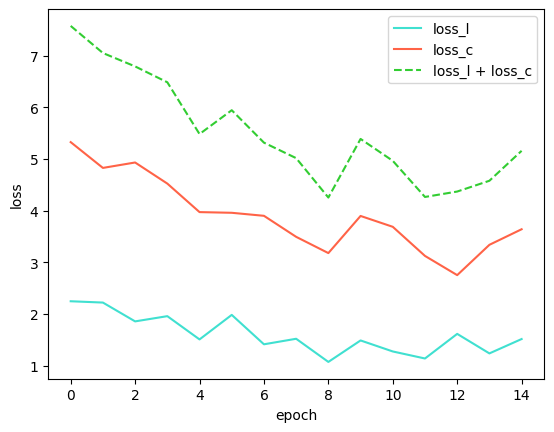

In [ ]:
## Lossを図示
x = range(epoch_num)
plt.plot(x, last_loss_list_by_epoch[0], color='turquoise', linestyle = '-')
plt.plot(x, last_loss_list_by_epoch[1], color='tomato', linestyle='-')
plt.plot(x, last_loss_list_by_epoch[2], color='limegreen', linestyle = '--')
plt.legend(['loss_l', 'loss_c', 'loss_l + loss_c'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

#### **推論プログラムの実装**

In [8]:
def ExeTest(img_path, model_path):
    net = SSD(phase='test')
    net.load_state_dict(torch.load(model_path))
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # <-- rgb_imageは最後の出力画像を出すときに使う
    x = cv2.resize(image, (300, 300)).astype(np.float32)
    x -= (104.0, 117.0, 123.0) # 平均画像を引く
    x = x.transpose(2, 0, 1) # [300, 300, 3]→[3, 300, 300]
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    net.eval()
    with torch.no_grad():
        y = net(x)

    labels = ['aeroplane', 'bicycle', 'bird', 'boat',
              'bottle', 'bus', 'car', 'cat', 'chair',
              'cow', 'diningtable', 'dog', 'horse',
              'motorbike', 'person', 'pottedplant',
              'sheep', 'sofa', 'train', 'tvmonitor']

    plt.figure(figsize=(10, 6))
    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
    plt.imshow(rgb_image)
    currentAxis = plt.gca()
    detections = y.data
    scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
    for i in range(detections.size(1)):
        j = 0
        # 確信度confが0.6以上のボックスを表示
        while detections[0, i, j, 0] >= 0.6:
            score = detections[0, i, j, 0]
            label_name = labels[i-1]
            display_txt = '%s: %.2f'%(label_name, score)
            pt = (detections[0, i, j, 1:] * scale).cpu().numpy()
            coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
            color = colors[i] ## クラスごとに色が決まっている
            currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
            currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
            j += 1
    plt.show()

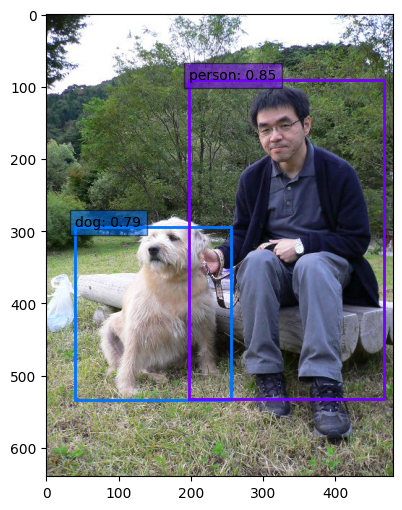

In [23]:
ExeTest(f"/content/drive/MyDrive/Ecode_Product/VOCdevkit/VOC2012/mydog.png", f"/content/drive/MyDrive/Ecode_Product/ssd3-{epoch_num-1}.model")

In [6]:
vf = open('/content/drive/MyDrive/Ecode_Product/VOCdevkit/VOC2012/ImageSets/Main/val.txt', 'r')
vfiles = vf.read().split('\n')
vindex = random.randint(0,len(vfiles)-1)

## **考察**

【工夫した点】  
① SSDの理解の為、転移学習やファインチューニングではなく、スクラッチで実装することにこだわった。  
② SSDの作成の際、VGG部分に既存の重みを利用することによって、学習精度および学習量のスケールダウンの向上を図った。  
③ DataAugmentationの実装を取り入れて、学習精度の向上を図った。
<br><br>
【課題点】  
① 一般公開されているようなモデルと比べ確信度は少し低めには出ている。
<br><br>
【今後の意向】  
① DataAugmentationを導入して、学習精度の向上を確認する。<br>
② 検出精度の評価について理解を深める（mAP）<br>
③ 転移学習やファインチューニングにより、オリジナルの画像やラベルに対して認識できるようにする。<br>
④ 動画についての検出を行う。<br>
⑤ YOLOなどの、その他の物体検出モデルについても、学習をすすめる。